In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import itertools

In [2]:
df=pd.read_excel("Superstore_Office_Supplies.xls")

In [3]:
#import pandas_profiling

In [4]:
#pandas_profiling.ProfileReport(df)

In [5]:
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


In [6]:
df.columns

Index(['Row ID', 'Order ID', 'Order Date', 'Ship Date', 'Ship Mode',
       'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State',
       'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category',
       'Product Name', 'Sales', 'Quantity', 'Discount', 'Profit'],
      dtype='object')

In [7]:
df=df.loc[:,['Order Date','Category','Sales']]

In [8]:
fur=df.loc[df["Category"]=='Furniture',['Order Date','Sales']]

In [9]:
fur.head(2)

,Order Date,Sales
0,2016-11-08,261.96
1,2016-11-08,731.94


In [84]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 3 columns):
Order Date    9994 non-null datetime64[ns]
Category      9994 non-null object
Sales         9994 non-null float64
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 234.4+ KB


In [10]:
fur.isna().sum()

Order Date    0
Sales         0
dtype: int64

In [11]:
#fur.set_index('Order Date', inplace=True)

In [12]:
fur=fur.groupby('Order Date')['Sales'].sum().reset_index()

In [13]:
fur.set_index('Order Date', inplace=True)

In [14]:
y=fur['Sales'].resample('M').mean()

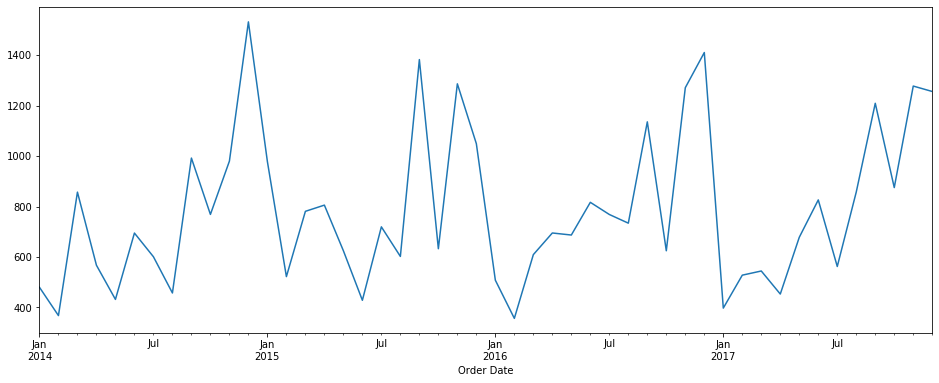

In [15]:
plt.rcParams['figure.figsize']=16,6
y.plot()

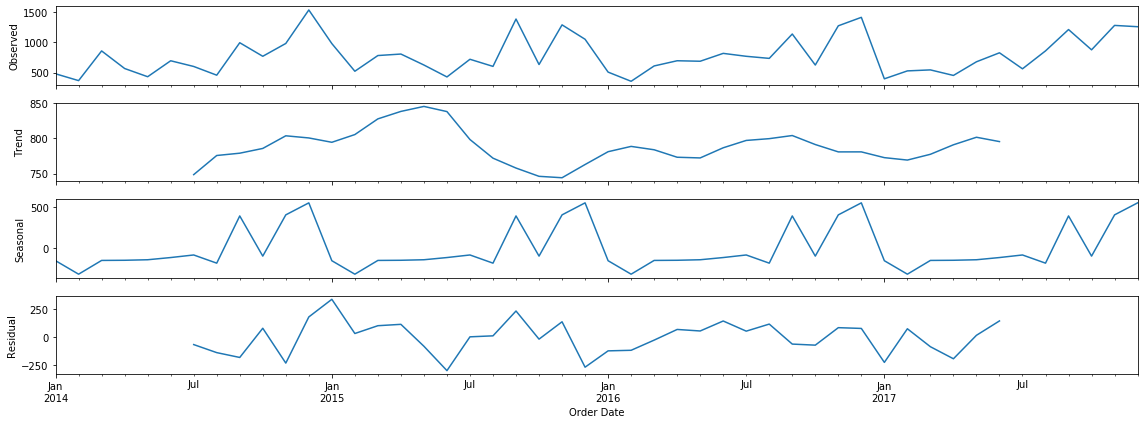

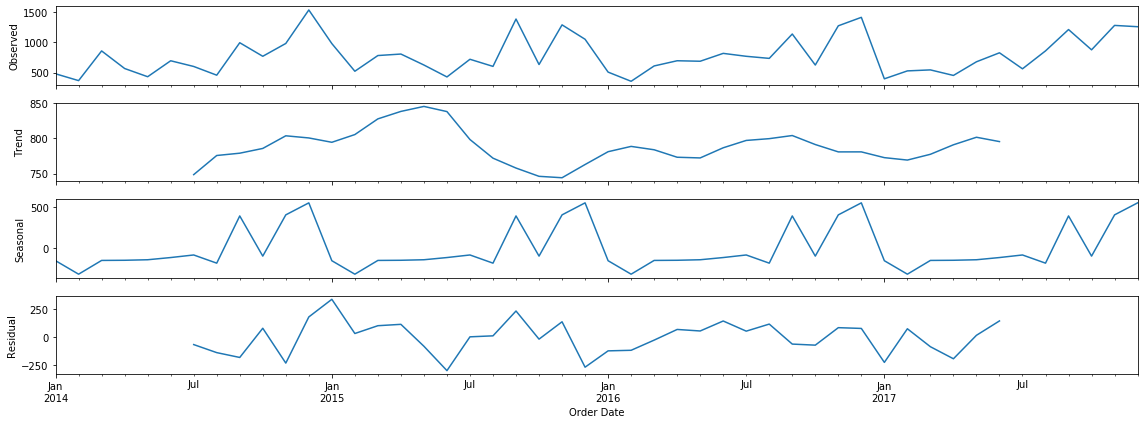

In [16]:
decomp=sm.tsa.seasonal_decompose(y)
decomp.plot()

In [21]:
result=sm.tsa.stattools.adfuller(y)
print("ADF",result[0])
print("p-vals",result[1])

ADF -5.1910701873392675
p-vals 9.16875665566581e-06


In [24]:
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12,center=False).mean() 
    rolstd = timeseries.rolling(window=12,center=False).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = sm.tsa.stattools.adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    
    #Plotting ACF
    sm.tsa.graphics.plot_acf(timeseries)
    print (dfoutput)

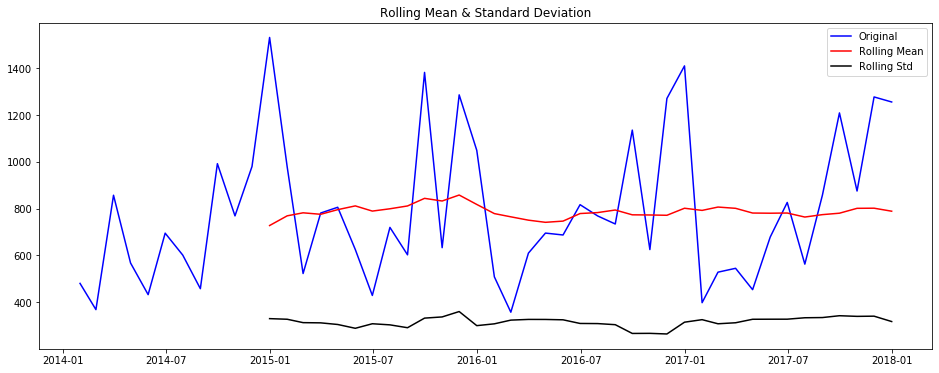

Results of Dickey-Fuller Test:
Test Statistic                 -5.191070
p-value                         0.000009
#Lags Used                     10.000000
Number of Observations Used    37.000000
Critical Value (1%)            -3.620918
Critical Value (5%)            -2.943539
Critical Value (10%)           -2.610400
dtype: float64


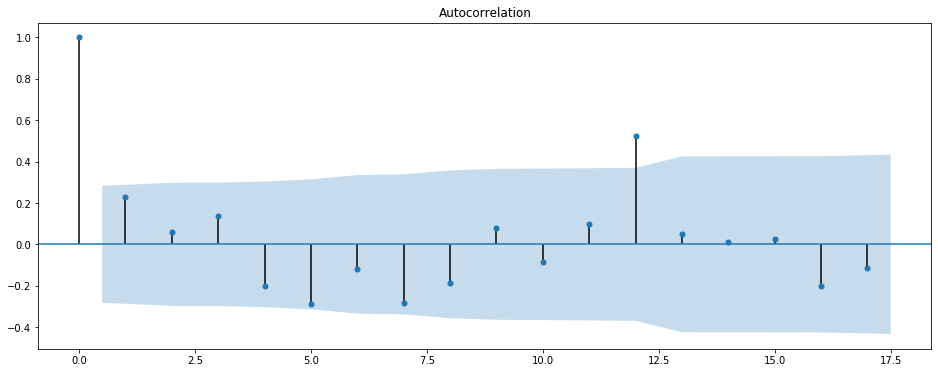

In [25]:
test_stationarity(y)

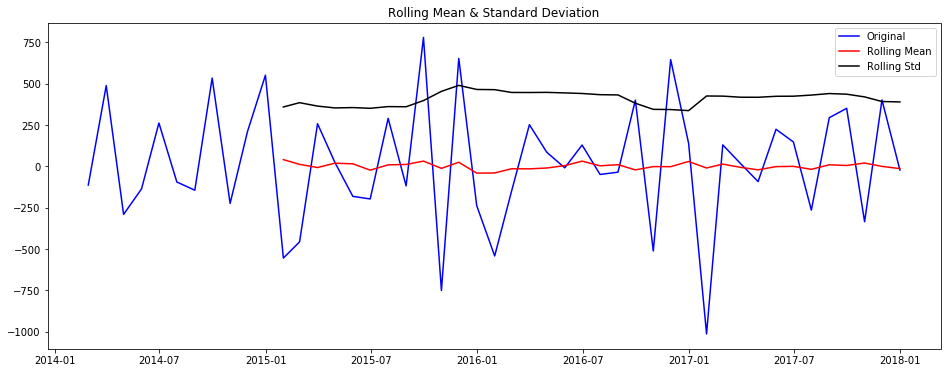

Results of Dickey-Fuller Test:
Test Statistic                -6.981398e+00
p-value                        8.174525e-10
#Lags Used                     1.000000e+01
Number of Observations Used    3.600000e+01
Critical Value (1%)           -3.626652e+00
Critical Value (5%)           -2.945951e+00
Critical Value (10%)          -2.611671e+00
dtype: float64


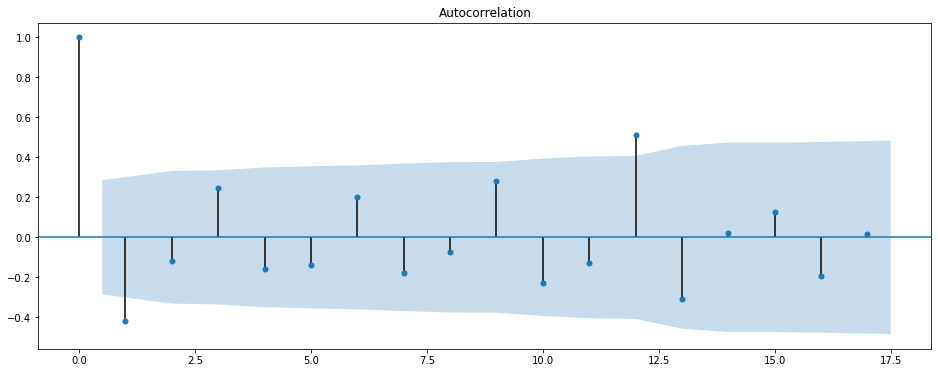

In [26]:
#first order differencing
test_stationarity(y.diff().dropna())

Fast decay in acf plot. TS is stationary

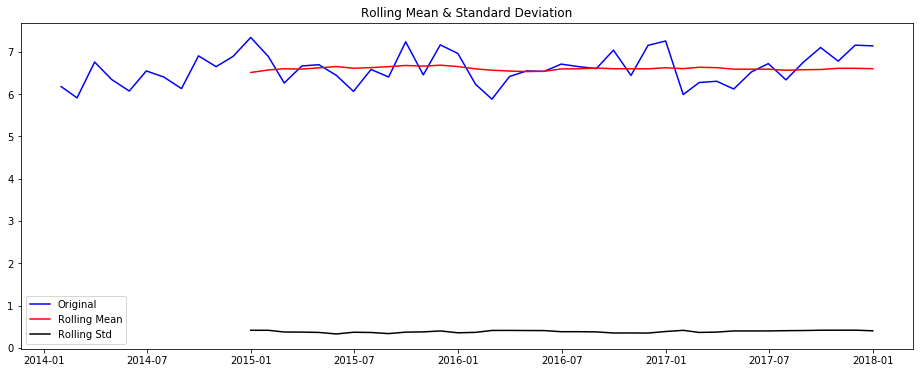

Results of Dickey-Fuller Test:
Test Statistic                 -4.856299
p-value                         0.000042
#Lags Used                      9.000000
Number of Observations Used    38.000000
Critical Value (1%)            -3.615509
Critical Value (5%)            -2.941262
Critical Value (10%)           -2.609200
dtype: float64


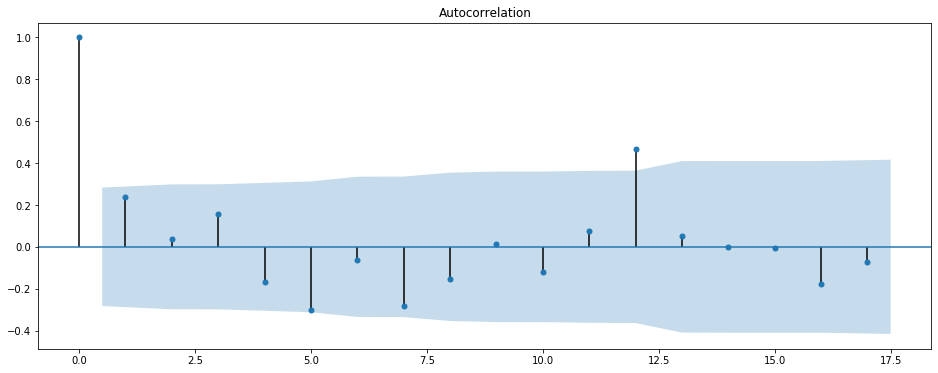

In [29]:
#log transf
test_stationarity(np.log(y).dropna())


Slow decay in ACF as compared to 1st order differencing

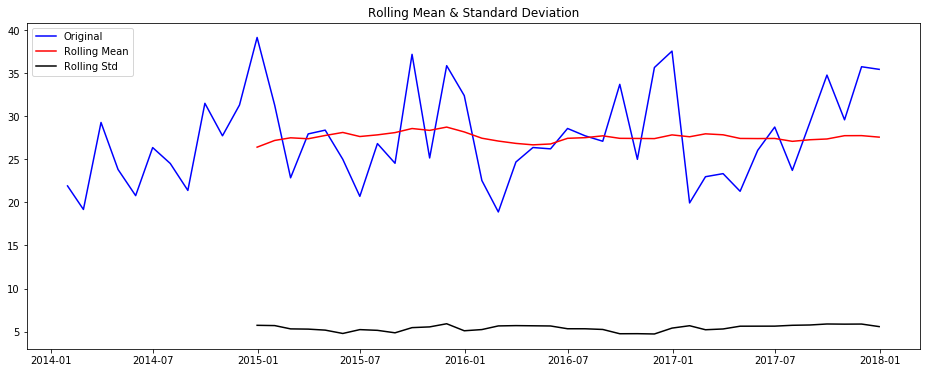

Results of Dickey-Fuller Test:
Test Statistic                 -4.978538
p-value                         0.000024
#Lags Used                      9.000000
Number of Observations Used    38.000000
Critical Value (1%)            -3.615509
Critical Value (5%)            -2.941262
Critical Value (10%)           -2.609200
dtype: float64


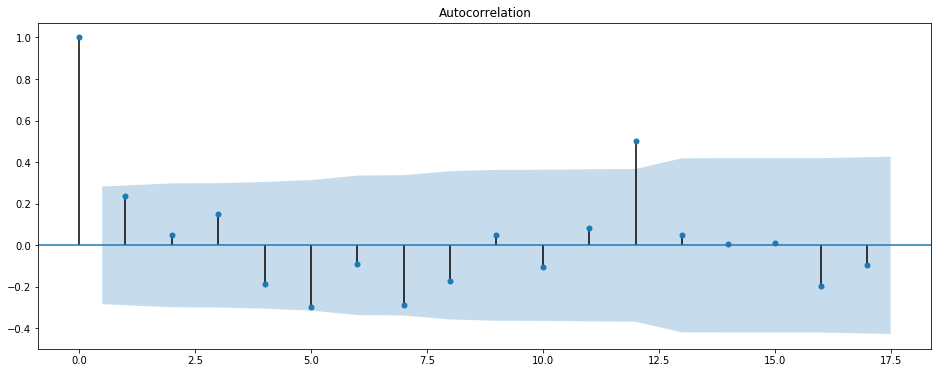

In [31]:
#Square root transformation
test_stationarity(np.sqrt(y).dropna())


Slow ACF decay as compared to 1st order differencing

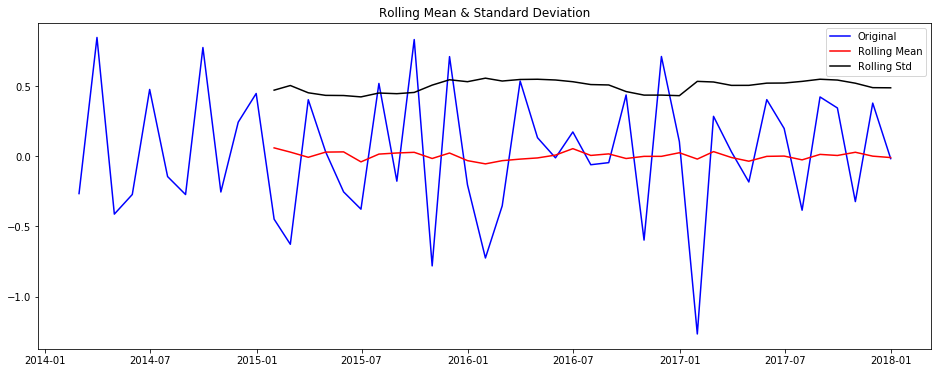

Results of Dickey-Fuller Test:
Test Statistic                -5.972473e+00
p-value                        1.921681e-07
#Lags Used                     1.000000e+01
Number of Observations Used    3.600000e+01
Critical Value (1%)           -3.626652e+00
Critical Value (5%)           -2.945951e+00
Critical Value (10%)          -2.611671e+00
dtype: float64


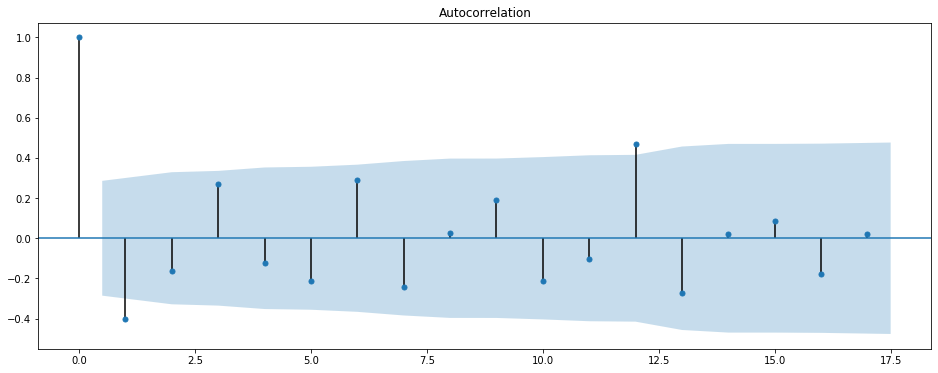

In [32]:
#log and diff transformation
test_stationarity(np.log(y).diff().dropna())

We have a heigher ADF for 1st order differencing as compared to diff+log transform. We will stick with differencing and try the next order differencing.

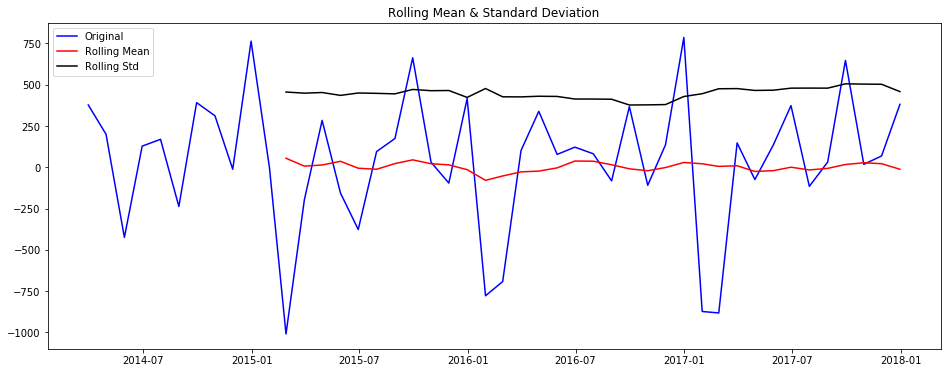

Results of Dickey-Fuller Test:
Test Statistic                -7.457185e+00
p-value                        5.473077e-11
#Lags Used                     9.000000e+00
Number of Observations Used    3.600000e+01
Critical Value (1%)           -3.626652e+00
Critical Value (5%)           -2.945951e+00
Critical Value (10%)          -2.611671e+00
dtype: float64


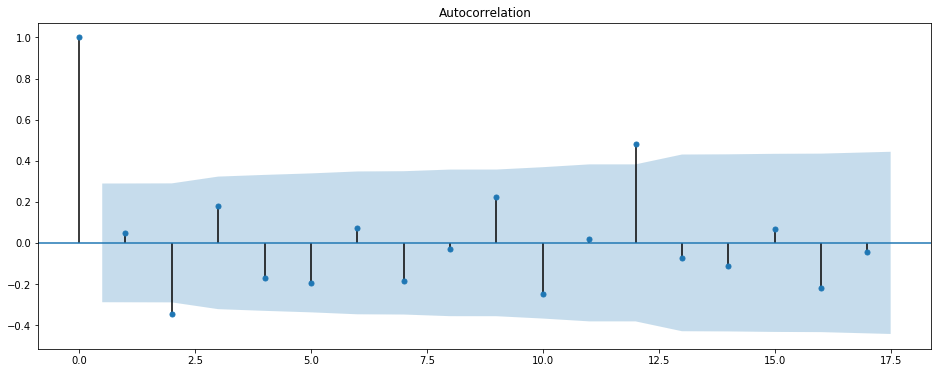

In [33]:
test_stationarity(y.diff(periods=2).dropna())

Less sudden decay in ACF as compared to 1st order differencing. So we will stick with 1st orde differecing and ACF of order 1

In [43]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in pdq]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [44]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:769.0817523205916
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1576.7324642473277
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:477.71701309202774
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:497.23144334183365
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1478.1277236759956
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:318.0047199116341
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:720.9252270758104
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:2786.7230874852653
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:466.56074298091505
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:499.59412606125284
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:2768.427220528199
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:319.98848769468674
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:677.894766843944
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1378.5486237111134
ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:486.63785671879367
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:497.78896630044073
ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:1022.8611228052164
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:319.7714068109211

selecting ARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:297.787543953291 with lowest AIC as returned by model

In [74]:
ts=sm.tsa.statespace.SARIMAX(y,
                             order=(1, 1, 1),seasonal_order=(1, 1, 0, 12),
                             enforce_stationarity=False,
                             enforce_invertibility=False)

In [75]:
results=ts.fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                              Sales   No. Observations:                   48
Model:             SARIMAX(1, 1, 1)x(1, 1, 0, 12)   Log Likelihood                -144.894
Date:                            Tue, 15 Oct 2019   AIC                            297.788
Time:                                    09:40:24   BIC                            302.152
Sample:                                01-31-2014   HQIC                           298.816
                                     - 12-31-2017                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0146      0.342      0.043      0.966      -0.655       0.684
ma.L1         -1.0000      0.360     -2.781      0.005      -1.705      -0.295
ar.S.L12      -0.0253      0.042     -0.609      0.543      -0.107       0.056
sigma2      2.958e+04   1.22e-05   2.43e+09      0.000    2.96e+04    2.96e+04
===================================================================================
Ljung-Box (Q):                         nan   Jarque-Bera (JB):                 0.84
Prob(Q):                               nan   Prob(JB):                         0.66
Heteroskedasticity (H):               0.55   Skew:                             0.44
Prob(H) (two-sided):                  0.45   Kurtosis:                         2.62
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.13e+24. Standard errors may be unstable.
"""

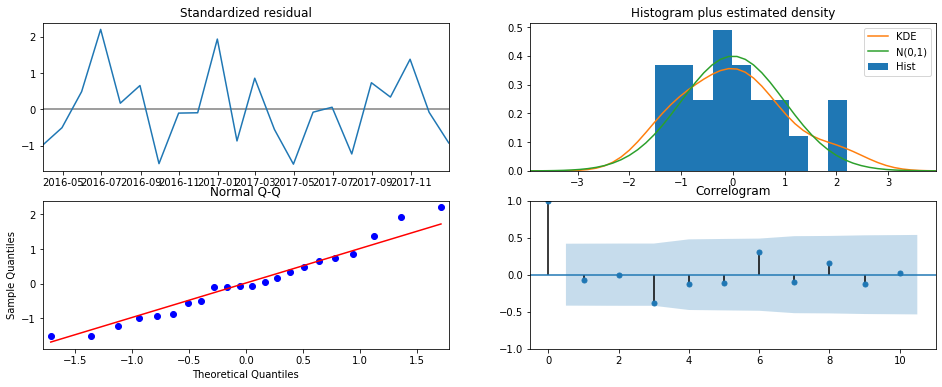

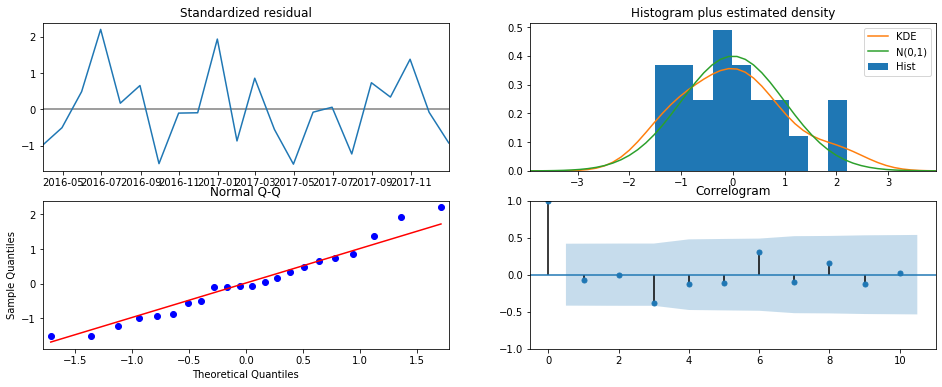

In [76]:
results.plot_diagnostics()

In [113]:
pred = results.get_prediction(start=pd.to_datetime('2017-05-31'), dynamic=False)
pred_ci = pred.conf_int()

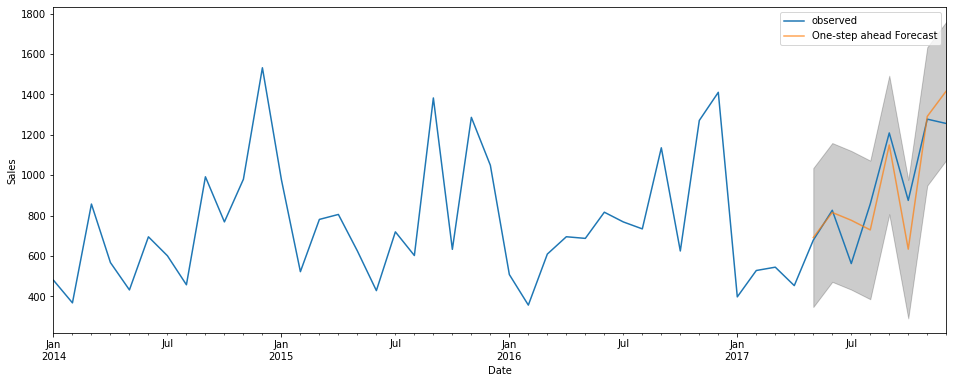

In [114]:
ax = y['2014':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Sales')
plt.legend()

plt.show()

In [106]:
y_r=y.reset_index()

In [115]:
y_r['Order Date']

0    2014-01-31
1    2014-02-28
2    2014-03-31
3    2014-04-30
4    2014-05-31
5    2014-06-30
6    2014-07-31
7    2014-08-31
8    2014-09-30
9    2014-10-31
10   2014-11-30
11   2014-12-31
12   2015-01-31
13   2015-02-28
14   2015-03-31
15   2015-04-30
16   2015-05-31
17   2015-06-30
18   2015-07-31
19   2015-08-31
20   2015-09-30
21   2015-10-31
22   2015-11-30
23   2015-12-31
24   2016-01-31
25   2016-02-29
26   2016-03-31
27   2016-04-30
28   2016-05-31
29   2016-06-30
30   2016-07-31
31   2016-08-31
32   2016-09-30
33   2016-10-31
34   2016-11-30
35   2016-12-31
36   2017-01-31
37   2017-02-28
38   2017-03-31
39   2017-04-30
40   2017-05-31
41   2017-06-30
42   2017-07-31
43   2017-08-31
44   2017-09-30
45   2017-10-31
46   2017-11-30
47   2017-12-31
Name: Order Date, dtype: datetime64[ns]

In [117]:
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse,
            'corr':corr, 'minmax':minmax})



In [118]:
y_forecasted = pred.predicted_mean
y_truth = y['2017-05-31':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))


The Mean Squared Error of our forecasts is 18841.31
The Root Mean Squared Error of our forecasts is 137.26


In [119]:
forecast_accuracy(y_forecasted, y_truth)

{'mape': 0.128401799008434,
 'me': -4.820683273075801,
 'mae': 105.29846073153341,
 'mpe': 0.006378056251669047,
 'rmse': 137.26366253929166,
 'corr': 0.8744276148027936,
 'minmax': 0.11337500146763513}

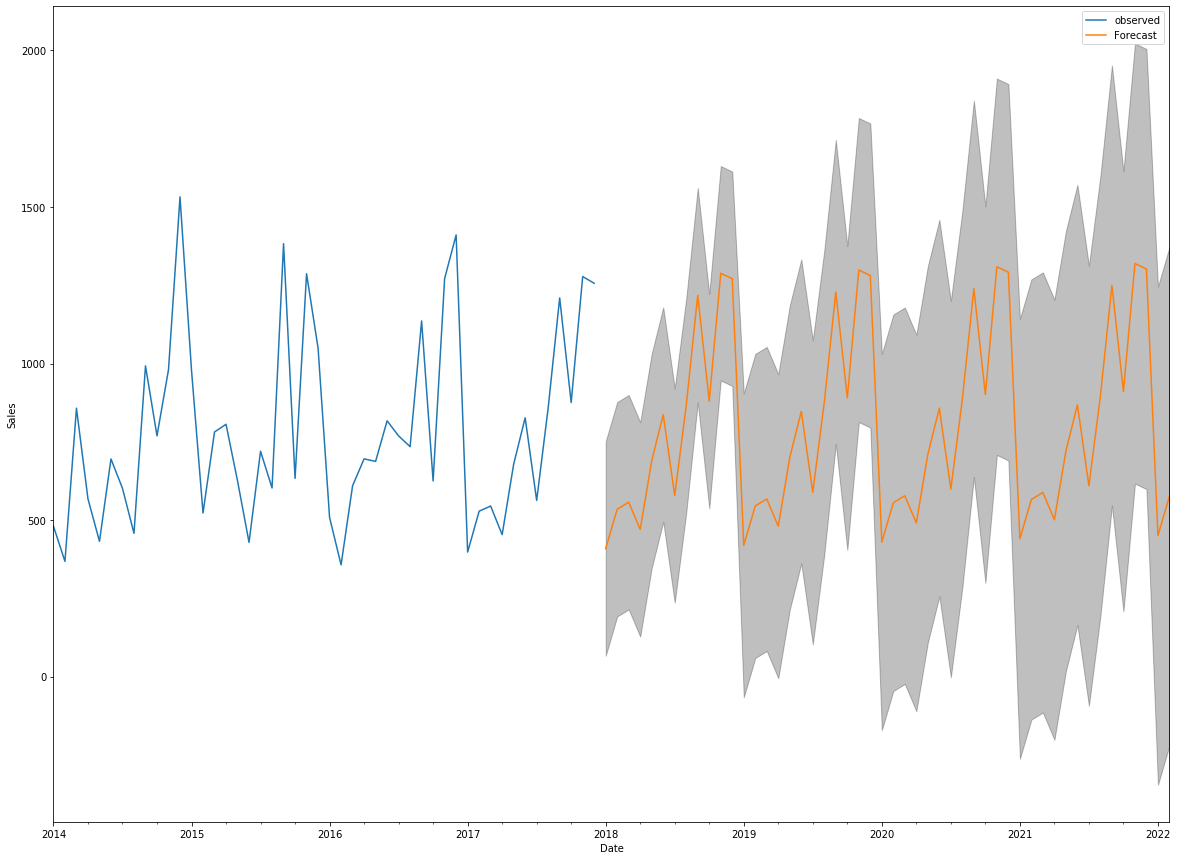

In [123]:
# Get forecast 500 steps ahead in future
pred_uc = results.get_forecast(steps=50)
# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()
#We can use the output of this code to plot the time series and forecasts of its future values.

ax = y.plot(label='observed', figsize=(20, 15))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Sales')

plt.legend()
plt.show()

In [126]:
print(pred_uc.predicted_mean)

2018-01-31     408.746868
2018-02-28     534.436207
2018-03-31     556.941166
2018-04-30     470.052301
2018-05-31     689.155640
2018-06-30     836.844973
2018-07-31     578.371393
2018-08-31     865.380111
2018-09-30    1218.273002
2018-10-31     879.648149
2018-11-30    1288.280331
2018-12-31    1270.834167
2019-01-31     419.091168
2019-02-28     544.904252
2019-03-31     567.257009
2019-04-30     480.254596
2019-05-31     699.507318
2019-06-30     847.208514
2019-07-31     588.596671
2019-08-31     875.816721
2019-09-30    1228.677559
2019-10-31     890.166089
2019-11-30    1298.641900
2019-12-31    1281.092632
2020-01-31     429.455731
2020-02-29     555.265683
2020-03-31     577.622292
2020-04-30     490.622754
2020-05-31     709.871694
2020-06-30     857.572589
2020-07-31     598.964247
2020-08-31     886.178947
2020-09-30    1239.040596
2020-10-31     900.526256
2020-11-30    1309.006025
2020-12-31    1291.459368
2021-01-31     439.819781
2021-02-28     565.629812
2021-03-31  